In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [4]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [5]:
forecasting = 20

In [6]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [7]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

<AxesSubplot:>

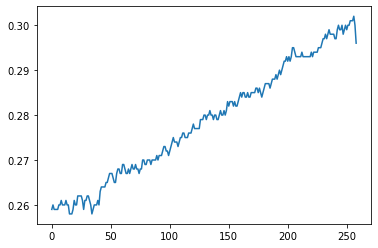

In [8]:
df.plot()

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [10]:
train = df_scaled

In [11]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [12]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [13]:
x_train.shape

(191, 20, 1)

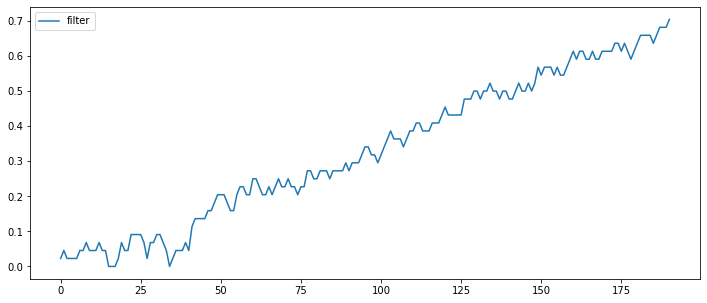

In [14]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

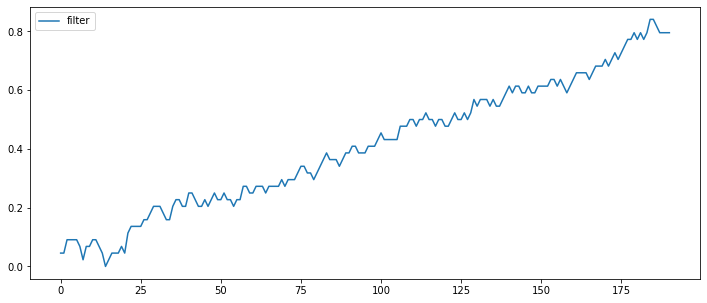

In [15]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [16]:
OUT_STEPS = 20

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [18]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
12/12 [==============================] - 1s 6ms/step - loss: 0.1628 - mean_absolute_error: 0.3399
Epoch 2/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.1581 - mean_absolute_error: 0.3402
Epoch 3/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.1481 - mean_absolute_error: 0.3209
Epoch 4/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.1006 - mean_absolute_error: 0.2557
Epoch 5/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0536 - mean_absolute_error: 0.1742
Epoch 6/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0299 - mean_absolute_error: 0.1249
Epoch 7/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0156 - mean_absolute_error: 0.0905
Epoch 8/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0617
Epoch 9/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0527
E

12/12 [==============================] - 0s 4ms/step - loss: 5.4488e-04 - mean_absolute_error: 0.0185
Epoch 73/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.5833e-04 - mean_absolute_error: 0.0187
Epoch 74/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.2480e-04 - mean_absolute_error: 0.0181
Epoch 75/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.4751e-04 - mean_absolute_error: 0.0185
Epoch 76/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1537e-04 - mean_absolute_error: 0.0181
Epoch 77/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.1318e-04 - mean_absolute_error: 0.0195
Epoch 78/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.4353e-04 - mean_absolute_error: 0.0184
Epoch 79/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.5218e-04 - mean_absolute_error: 0.0185
Epoch 80/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.3319e-04 

12/12 [==============================] - 0s 4ms/step - loss: 5.3777e-04 - mean_absolute_error: 0.0183
Epoch 143/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.3392e-04 - mean_absolute_error: 0.0182
Epoch 144/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1777e-04 - mean_absolute_error: 0.0180
Epoch 145/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.2948e-04 - mean_absolute_error: 0.0182
Epoch 146/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.4674e-04 - mean_absolute_error: 0.0185
Epoch 147/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.0122e-04 - mean_absolute_error: 0.0177
Epoch 148/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.4879e-04 - mean_absolute_error: 0.0185
Epoch 149/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.3351e-04 - mean_absolute_error: 0.0184
Epoch 150/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.6

12/12 [==============================] - 0s 4ms/step - loss: 4.7461e-04 - mean_absolute_error: 0.0174
Epoch 213/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.5413e-04 - mean_absolute_error: 0.0170
Epoch 214/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.6986e-04 - mean_absolute_error: 0.0175
Epoch 215/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.9181e-04 - mean_absolute_error: 0.0178
Epoch 216/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.8424e-04 - mean_absolute_error: 0.0176
Epoch 217/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.9457e-04 - mean_absolute_error: 0.0176
Epoch 218/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.9859e-04 - mean_absolute_error: 0.0179
Epoch 219/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.4181e-04 - mean_absolute_error: 0.0167
Epoch 220/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.8

12/12 [==============================] - 0s 4ms/step - loss: 4.1971e-04 - mean_absolute_error: 0.0165
Epoch 282/1000
12/12 [==============================] - 0s 6ms/step - loss: 4.0124e-04 - mean_absolute_error: 0.0161
Epoch 283/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.2371e-04 - mean_absolute_error: 0.0164
Epoch 284/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.1741e-04 - mean_absolute_error: 0.0165
Epoch 285/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.9865e-04 - mean_absolute_error: 0.0161
Epoch 286/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.9413e-04 - mean_absolute_error: 0.0159
Epoch 287/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.0484e-04 - mean_absolute_error: 0.0162
Epoch 288/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.1451e-04 - mean_absolute_error: 0.0164
Epoch 289/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.9

12/12 [==============================] - 0s 4ms/step - loss: 3.6870e-04 - mean_absolute_error: 0.0155
Epoch 352/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7164e-04 - mean_absolute_error: 0.0154
Epoch 353/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7843e-04 - mean_absolute_error: 0.0156
Epoch 354/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6184e-04 - mean_absolute_error: 0.0152
Epoch 355/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.9021e-04 - mean_absolute_error: 0.0159
Epoch 356/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.5612e-04 - mean_absolute_error: 0.0152
Epoch 357/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.6736e-04 - mean_absolute_error: 0.0154
Epoch 358/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.8162e-04 - mean_absolute_error: 0.0157
Epoch 359/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.7

12/12 [==============================] - 0s 4ms/step - loss: 3.5726e-04 - mean_absolute_error: 0.0151
Epoch 422/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6274e-04 - mean_absolute_error: 0.0152
Epoch 423/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.4174e-04 - mean_absolute_error: 0.0148
Epoch 424/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.4192e-04 - mean_absolute_error: 0.0149
Epoch 425/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6131e-04 - mean_absolute_error: 0.0152
Epoch 426/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.6536e-04 - mean_absolute_error: 0.0153
Epoch 427/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3718e-04 - mean_absolute_error: 0.0147
Epoch 428/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.4392e-04 - mean_absolute_error: 0.0149
Epoch 429/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6

12/12 [==============================] - 0s 4ms/step - loss: 3.4984e-04 - mean_absolute_error: 0.0150
Epoch 492/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.5333e-04 - mean_absolute_error: 0.0150
Epoch 493/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3803e-04 - mean_absolute_error: 0.0148
Epoch 494/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2020e-04 - mean_absolute_error: 0.0144
Epoch 495/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2728e-04 - mean_absolute_error: 0.0145
Epoch 496/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3218e-04 - mean_absolute_error: 0.0147
Epoch 497/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3172e-04 - mean_absolute_error: 0.0146
Epoch 498/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.4190e-04 - mean_absolute_error: 0.0148
Epoch 499/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.5

Epoch 561/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2660e-04 - mean_absolute_error: 0.0145
Epoch 562/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2802e-04 - mean_absolute_error: 0.0145
Epoch 563/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.1842e-04 - mean_absolute_error: 0.0143
Epoch 564/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.3599e-04 - mean_absolute_error: 0.0147
Epoch 565/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2176e-04 - mean_absolute_error: 0.0144
Epoch 566/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3356e-04 - mean_absolute_error: 0.0146
Epoch 567/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2399e-04 - mean_absolute_error: 0.0145
Epoch 568/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0510e-04 - mean_absolute_error: 0.0139
Epoch 569/1000
12/12 [==============================] - 0s 4ms/s

12/12 [==============================] - 0s 4ms/step - loss: 3.0825e-04 - mean_absolute_error: 0.0140
Epoch 632/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.1721e-04 - mean_absolute_error: 0.0142
Epoch 633/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.1064e-04 - mean_absolute_error: 0.0141
Epoch 634/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0659e-04 - mean_absolute_error: 0.0140
Epoch 635/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2322e-04 - mean_absolute_error: 0.0143
Epoch 636/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0581e-04 - mean_absolute_error: 0.0139
Epoch 637/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0988e-04 - mean_absolute_error: 0.0141
Epoch 638/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.1339e-04 - mean_absolute_error: 0.0141
Epoch 639/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.1

12/12 [==============================] - 0s 4ms/step - loss: 3.2066e-04 - mean_absolute_error: 0.0143
Epoch 702/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2824e-04 - mean_absolute_error: 0.0145
Epoch 703/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9313e-04 - mean_absolute_error: 0.0137
Epoch 704/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9985e-04 - mean_absolute_error: 0.0138
Epoch 705/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0987e-04 - mean_absolute_error: 0.0140
Epoch 706/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2024e-04 - mean_absolute_error: 0.0143
Epoch 707/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.1303e-04 - mean_absolute_error: 0.0141
Epoch 708/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0661e-04 - mean_absolute_error: 0.0140
Epoch 709/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.1

12/12 [==============================] - 0s 4ms/step - loss: 3.0504e-04 - mean_absolute_error: 0.0139
Epoch 772/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.1431e-04 - mean_absolute_error: 0.0141
Epoch 773/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0964e-04 - mean_absolute_error: 0.0141
Epoch 774/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9117e-04 - mean_absolute_error: 0.0137
Epoch 775/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.1621e-04 - mean_absolute_error: 0.0141
Epoch 776/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.1115e-04 - mean_absolute_error: 0.0141
Epoch 777/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0230e-04 - mean_absolute_error: 0.0138
Epoch 778/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0302e-04 - mean_absolute_error: 0.0140
Epoch 779/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0

12/12 [==============================] - 0s 4ms/step - loss: 3.1113e-04 - mean_absolute_error: 0.0141
Epoch 842/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.1562e-04 - mean_absolute_error: 0.0141
Epoch 843/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9895e-04 - mean_absolute_error: 0.0138
Epoch 844/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9867e-04 - mean_absolute_error: 0.0138
Epoch 845/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9582e-04 - mean_absolute_error: 0.0137
Epoch 846/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.8958e-04 - mean_absolute_error: 0.0135
Epoch 847/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9701e-04 - mean_absolute_error: 0.0138
Epoch 848/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9254e-04 - mean_absolute_error: 0.0136
Epoch 849/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0

12/12 [==============================] - 0s 4ms/step - loss: 2.8803e-04 - mean_absolute_error: 0.0136
Epoch 912/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9820e-04 - mean_absolute_error: 0.0138
Epoch 913/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9938e-04 - mean_absolute_error: 0.0137
Epoch 914/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9344e-04 - mean_absolute_error: 0.0137
Epoch 915/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9324e-04 - mean_absolute_error: 0.0137
Epoch 916/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9751e-04 - mean_absolute_error: 0.0137
Epoch 917/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9220e-04 - mean_absolute_error: 0.0137
Epoch 918/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0174e-04 - mean_absolute_error: 0.0139
Epoch 919/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9

12/12 [==============================] - 0s 5ms/step - loss: 2.9571e-04 - mean_absolute_error: 0.0137
Epoch 982/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9118e-04 - mean_absolute_error: 0.0136
Epoch 983/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9894e-04 - mean_absolute_error: 0.0138
Epoch 984/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9367e-04 - mean_absolute_error: 0.0137
Epoch 985/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.7985e-04 - mean_absolute_error: 0.0133
Epoch 986/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9609e-04 - mean_absolute_error: 0.0137
Epoch 987/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9664e-04 - mean_absolute_error: 0.0137
Epoch 988/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9222e-04 - mean_absolute_error: 0.0137
Epoch 989/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8

num 0 25.936293601989828 actual 0.6190476190476186 prediction 0.7796056
num 1 18.140712380409347 actual 0.6666666666666661 prediction 0.78760475
num 2 10.851894617080807 actual 0.7142857142857135 prediction 0.79179925
num 3 3.2615266740320967 actual 0.7619047619047628 prediction 0.7867545
num 4 10.721876621246455 actual 0.7142857142857135 prediction 0.79087055
num 5 19.398212432861435 actual 0.6666666666666661 prediction 0.7959881
num 6 19.109848141670334 actual 0.6666666666666661 prediction 0.79406565
num 7 20.94919085502635 actual 0.6666666666666661 prediction 0.80632794
num 8 12.46948003768933 actual 0.7142857142857135 prediction 0.8033534
num 9 15.112247467041136 actual 0.7142857142857135 prediction 0.82223034
num 10 16.177275180816775 actual 0.7142857142857135 prediction 0.8298377
num 11 25.777408480644336 actual 0.6666666666666661 prediction 0.83851606
num 12 16.443786621093874 actual 0.7142857142857135 prediction 0.83174133
num 13 11.031180992722387 actual 0.7619047619047628 pre

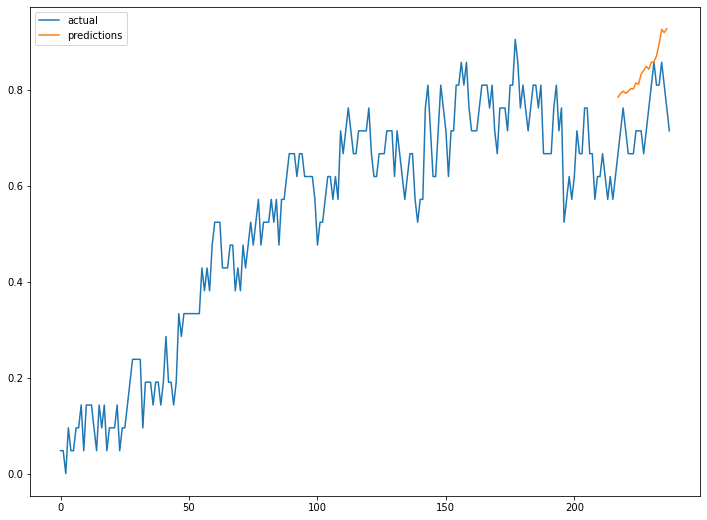

In [19]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.645179699878281 actual 0.8006535947712417 prediction 0.79548794
num 1 0.6781445395561966 actual 0.8104575163398693 prediction 0.80496144
num 2 0.5234475595405298 actual 0.8137254901960784 prediction 0.80946606
num 3 1.3984938621520977 actual 0.8169934640522876 prediction 0.80556786
num 4 1.1625611782073955 actual 0.8169934640522876 prediction 0.8074954
num 5 0.10612552384456653 actual 0.8202614379084967 prediction 0.82113194
num 6 0.6581138245201803 actual 0.826797385620915 prediction 0.8213561
num 7 0.8570784237235889 actual 0.8366013071895424 prediction 0.84377164
num 8 2.149876020129569 actual 0.8464052287581698 prediction 0.82820857
num 9 0.30254659981561494 actual 0.8529411764705881 prediction 0.85036063
num 10 0.5931521096610105 actual 0.8594771241830064 prediction 0.8543791
num 11 0.6725767796689608 actual 0.8627450980392155 prediction 0.8569425
num 12 1.6421338747132284 actual 0.8660130718954246 prediction 0.851792
num 13 1.2115759669609574 actual 0.8660130718954246 pre

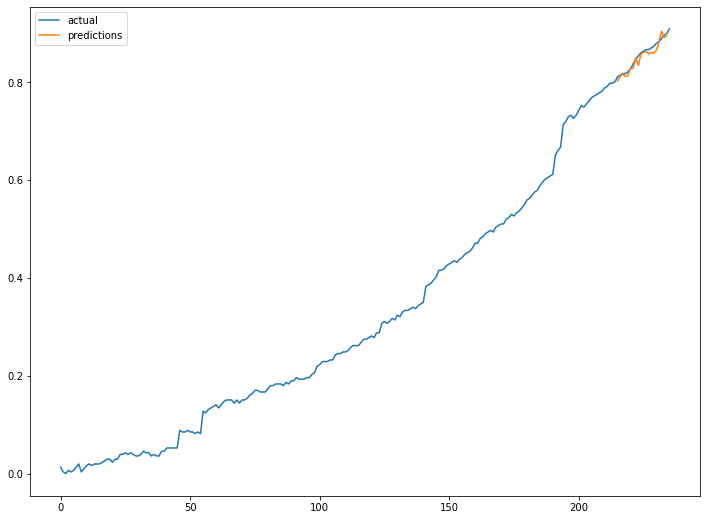

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.12989419307486877 actual 0.6762402088772845 prediction 0.6753618
num 1 1.0576874920815975 actual 0.6892950391644908 prediction 0.68200445
num 2 1.7987208866447737 actual 0.6971279373368144 prediction 0.68458855
num 3 1.4853806743834324 actual 0.702349869451697 prediction 0.6919173
num 4 1.3141844325399747 actual 0.7075718015665795 prediction 0.698273
num 5 1.3322489975142682 actual 0.7154046997389034 prediction 0.7058737
num 6 2.5540097212705954 actual 0.7284595300261096 prediction 0.7098546
num 7 1.4618748279005431 actual 0.7389033942558747 prediction 0.72810155
num 8 2.3877644788097236 actual 0.7493472584856395 prediction 0.7314546
num 9 1.6368509576394745 actual 0.7545691906005221 prediction 0.742218
num 10 1.5567942690930594 actual 0.7650130548302871 prediction 0.7531034
num 11 0.6996882205106852 actual 0.7676240208877285 prediction 0.76225305
num 12 0.9223056893770464 actual 0.7676240208877285 prediction 0.7605442
num 13 0.9643846710256143 actual 0.7780678851174934 predict

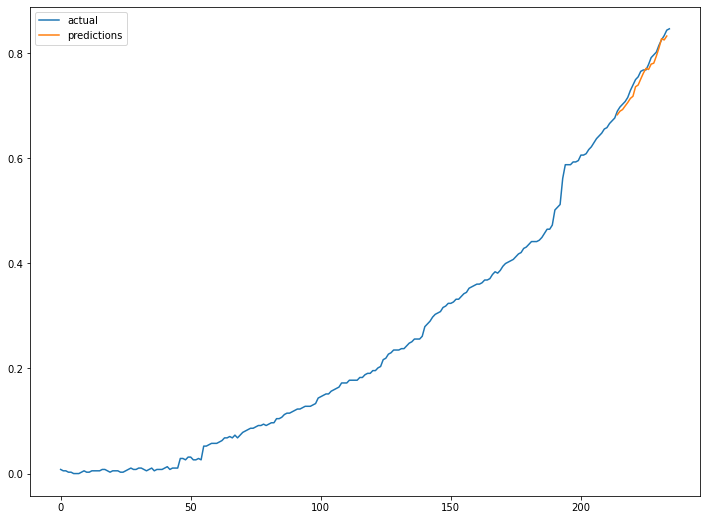

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.481403451216926 actual 0.7916666666666661 prediction 0.82714444
num 1 5.577069834659053 actual 0.7916666666666661 prediction 0.83581847
num 2 6.499569039595834 actual 0.7916666666666661 prediction 0.8431216
num 3 11.922454833984375 actual 0.75 prediction 0.8394184
num 4 6.368142680118039 actual 0.7916666666666661 prediction 0.8420811
num 5 13.996108373006185 actual 0.75 prediction 0.8549708
num 6 2.998707294464038 actual 0.8333333333333339 prediction 0.85832256
num 7 5.401351451873705 actual 0.8333333333333339 prediction 0.8783446
num 8 5.447522076693387 actual 0.9166666666666661 prediction 0.86673105
num 9 6.51818980341378 actual 0.9583333333333339 prediction 0.89586735
num 10 5.775294096573598 actual 0.9583333333333339 prediction 0.90298676
num 11 5.4016382797905225 actual 0.9583333333333339 prediction 0.90656763
num 12 5.86531058601717 actual 0.9583333333333339 prediction 0.9021241
num 13 4.944739134415395 actual 0.9583333333333339 prediction 0.91094625
num 14 0.949694893576

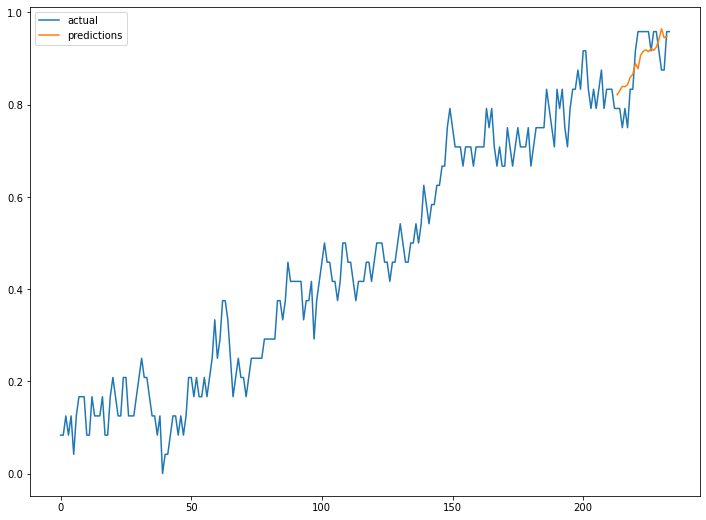

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.133257815712392 actual 0.8482142857142856 prediction 0.874791
num 1 3.530038396517482 actual 0.8571428571428568 prediction 0.8874003
num 2 5.003337860107438 actual 0.8482142857142856 prediction 0.8906533
num 3 2.843041944254162 actual 0.8526785714285712 prediction 0.8769206
num 4 1.0185605471896364 actual 0.8660714285714284 prediction 0.8748929
num 5 1.991128921508789 actual 0.875 prediction 0.8924224
num 6 0.9638026281056816 actual 0.8794642857142856 prediction 0.8879406
num 7 2.7958865141749225 actual 0.8883928571428568 prediction 0.9132313
num 8 0.27487494728779094 actual 0.8839285714285712 prediction 0.8814989
num 9 2.5892947786417877 actual 0.8883928571428568 prediction 0.91139597
num 10 2.759219660903498 actual 0.8839285714285712 prediction 0.9083181
num 11 1.5436525344848704 actual 0.8928571428571428 prediction 0.90663975
num 12 0.3573342125014153 actual 0.901785714285714 prediction 0.8985633
num 13 0.9456700292126885 actual 0.90625 prediction 0.89767987
num 14 1.4154236

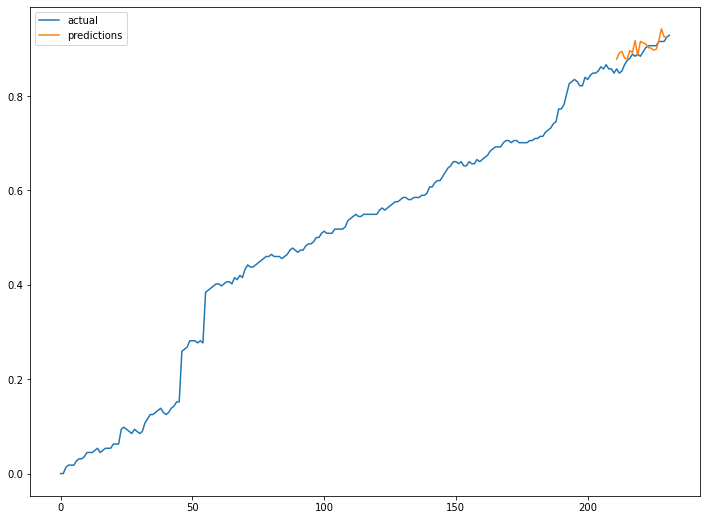

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.572873508228802 actual 0.8500000000000014 prediction 0.8803694
num 1 11.75304651260366 actual 0.8000000000000007 prediction 0.8940244
num 2 19.07538572947184 actual 0.75 prediction 0.8930654
num 3 16.683673858642578 actual 0.75 prediction 0.87512755
num 4 15.957299868265787 actual 0.75 prediction 0.86967975
num 5 18.235468864440918 actual 0.75 prediction 0.886766
num 6 25.17471824373499 actual 0.7000000000000011 prediction 0.876223
num 7 28.779087747846134 actual 0.7000000000000011 prediction 0.9014536
num 8 32.652915441072835 actual 0.6500000000000004 prediction 0.86224395
num 9 27.220528466360715 actual 0.7000000000000011 prediction 0.8905437
num 10 17.660021781921387 actual 0.75 prediction 0.88245016
num 11 17.06665356953939 actual 0.75 prediction 0.8779999
num 12 24.209361416952763 actual 0.7000000000000011 prediction 0.86946553
num 13 23.41289009366698 actual 0.7000000000000011 prediction 0.86389023
num 14 7.621788978576564 actual 0.8000000000000007 prediction 0.8609743
nu

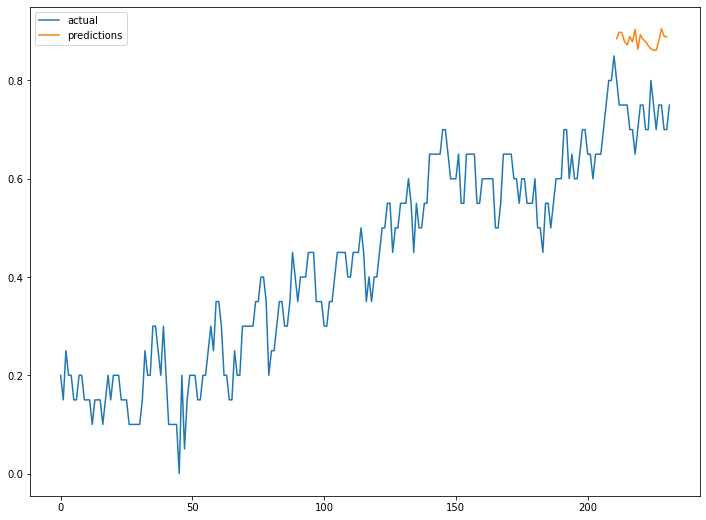

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 1.7987318336964784 actual 0.8421052631578938 prediction 0.8572525
num 1 0.0617337949348434 actual 0.8684210526315788 prediction 0.86895716
num 2 3.392376378178711 actual 0.8421052631578938 prediction 0.87067264
num 3 1.3512958179820456 actual 0.8684210526315788 prediction 0.8566861
num 4 1.648460734974233 actual 0.8684210526315788 prediction 0.8541055
num 5 2.998419106006737 actual 0.8421052631578938 prediction 0.8673551
num 6 5.426728725433453 actual 0.8157894736842097 prediction 0.86006016
num 7 8.06345362817098 actual 0.8157894736842097 prediction 0.8815703
num 8 1.3399254530669384 actual 0.8421052631578938 prediction 0.85338885
num 9 4.399880394339677 actual 0.8421052631578938 prediction 0.8791569
num 10 0.8944077925248798 actual 0.8684210526315788 prediction 0.8761883
num 11 4.0279641747475825 actual 0.8421052631578938 prediction 0.87602496
num 12 3.052057588801629 actual 0.8947368421052628 prediction 0.86742896
num 13 0.034190307963999696 actual 0.8684210526315788 predictio

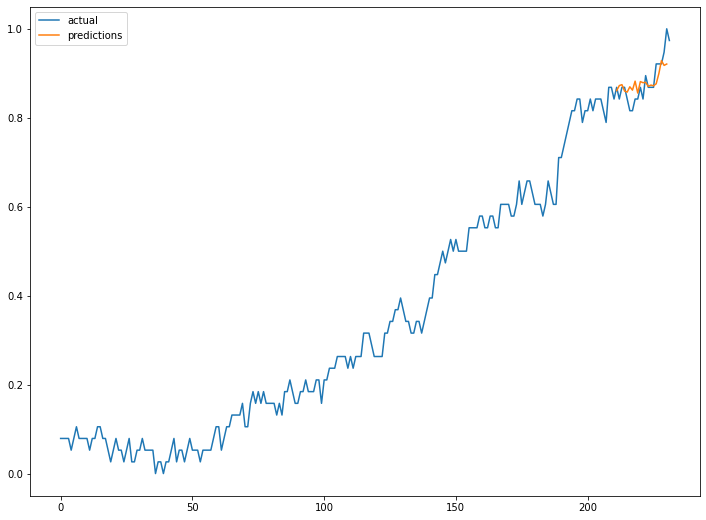

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.571217060089001 actual 0.76923076923077 prediction 0.79670167
num 1 10.30910768006963 actual 0.7307692307692317 prediction 0.806105
num 2 10.843255645350261 actual 0.7307692307692317 prediction 0.8100084
num 3 10.090238169619766 actual 0.7307692307692317 prediction 0.8045056
num 4 16.428222258885818 actual 0.6923076923076916 prediction 0.80604154
num 5 6.294580101966744 actual 0.76923076923077 prediction 0.8176506
num 6 1.0070948373702875 actual 0.8076923076923084 prediction 0.81582654
num 7 3.5590273993355006 actual 0.8076923076923084 prediction 0.8364383
num 8 2.9673408378254913 actual 0.8461538461538467 prediction 0.8210456
num 9 4.180362111046112 actual 0.8076923076923084 prediction 0.8414568
num 10 9.817893505096318 actual 0.76923076923077 prediction 0.844753
num 11 10.240037441253545 actual 0.76923076923077 prediction 0.8480003
num 12 9.423915743827703 actual 0.76923076923077 prediction 0.8417224
num 13 4.799446037837349 actual 0.8076923076923084 prediction 0.84645706
num

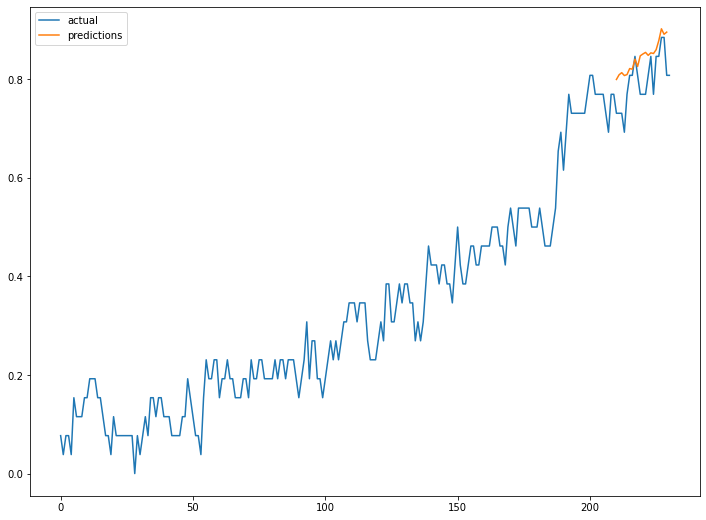

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 1.2945060332616494 actual 0.7389162561576352 prediction 0.7484816
num 1 1.0688976237648447 actual 0.7487684729064039 prediction 0.75677204
num 2 0.86673868247891 actual 0.7536945812807878 prediction 0.76022714
num 3 0.23483579809018884 actual 0.7586206896551722 prediction 0.7604022
num 4 0.6261689922748402 actual 0.7684729064039408 prediction 0.76366097
num 5 0.17096609067005006 actual 0.7733990147783252 prediction 0.77472126
num 6 0.3478653823272727 actual 0.7783251231527091 prediction 0.7756176
num 7 1.6682266064410172 actual 0.7832512315270934 prediction 0.79631764
num 8 0.0722466409206296 actual 0.7881773399014778 prediction 0.7876079
num 9 1.4561336973439052 actual 0.7931034482758621 prediction 0.8046521
num 10 1.6129685772790243 actual 0.798029556650246 prediction 0.8109015
num 11 2.2119207882587215 actual 0.798029556650246 prediction 0.81568134
num 12 0.486498089825247 actual 0.8078817733990147 prediction 0.8118121
num 13 0.6446421860220629 actual 0.8226600985221673 predic

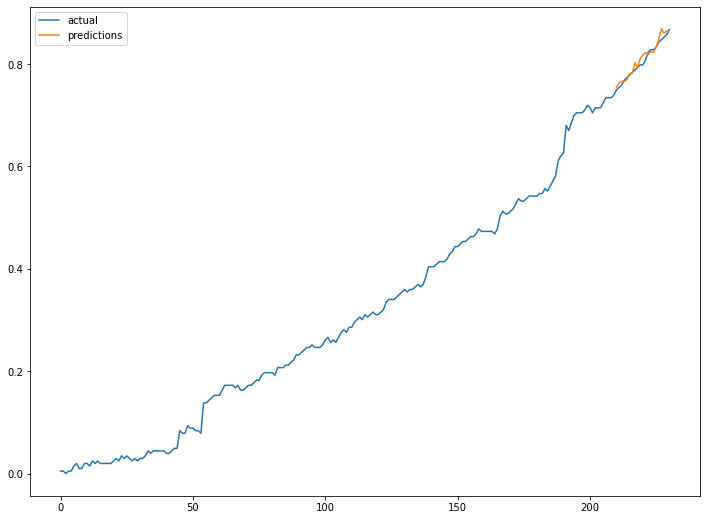

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()